# Buy and Hold Returns

What if you invested $1 in the US Stock Market and never sold?

How would your $1 grow if you invested at all time highs or at relative lows?

This notebook examines making that investment at every single point since 1970 (well not every point, every quarter).

Now \\$1 invested on Jan 1 1970 has a 50 years of data while \\$1 invested on Jan 1 2021 has just 1. You'll see this in the graph.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas.tseries import frequencies

In [2]:
# Willshire 5000 total market cap (includes div reinvested)
# https://fred.stlouisfed.org/series/WILL5000INDFC
symbol = "WILL5000INDFC"  

# buy and hold strategy, examine every buy date at this frequency
# https://github.com/pandas-dev/pandas/blob/master/doc/source/user_guide/timeseries.rst#dateoffset-objects
buy_freq = "Q"

df = pdr.get_data_fred(symbol, start=1970)
prices = df[symbol]

In [5]:
def rolling_buy_and_hold_returns(prices: pd.Series, buy_freq: frequencies.DateOffset):
    """Cumulative buy-and-hold returns for every possible buy date occurring
    every buy_freq.
    
    Assumes you invest $1 on the buy date and never sell.
    """
    prices = prices.resample(buy_freq).last()
    n = len(prices)

    # each column is the cumulative returns for single buy-date
    # from left to right, the columns represent later and later buy-dates
    data = np.empty((n, n), dtype=np.float64)
    data[:] = np.nan
    
    for i in range(n):
        vector = prices.iloc[i:]
        vector = vector / vector.iloc[0]
        data[:len(vector), i] = vector
        
    return pd.DataFrame(
        data,
        columns=prices.index,
    )


def plot_tseries_with_colorbar_legend(
    tseries: pd.DataFrame, cmap="viridis", date_format="%b %Y", facecolor='white', **kwargs
):

    vmin, vmax = df.index[0].value, df.index[-1].value
    norm = plt.Normalize(vmin, vmax)
    sm = plt.cm.ScalarMappable(norm, cmap)
    sm._A = []  

    fig, ax = plt.subplots()
    fig.patch.set_facecolor(facecolor)
    ax = tseries.plot(ax=ax, legend=False, colormap=cmap, **kwargs)
    cbar = plt.colorbar(sm)
    cbar.ax.set_yticklabels(
        pd.to_datetime(cbar.get_ticks()).strftime(date_format)
    )
    return ax, cbar

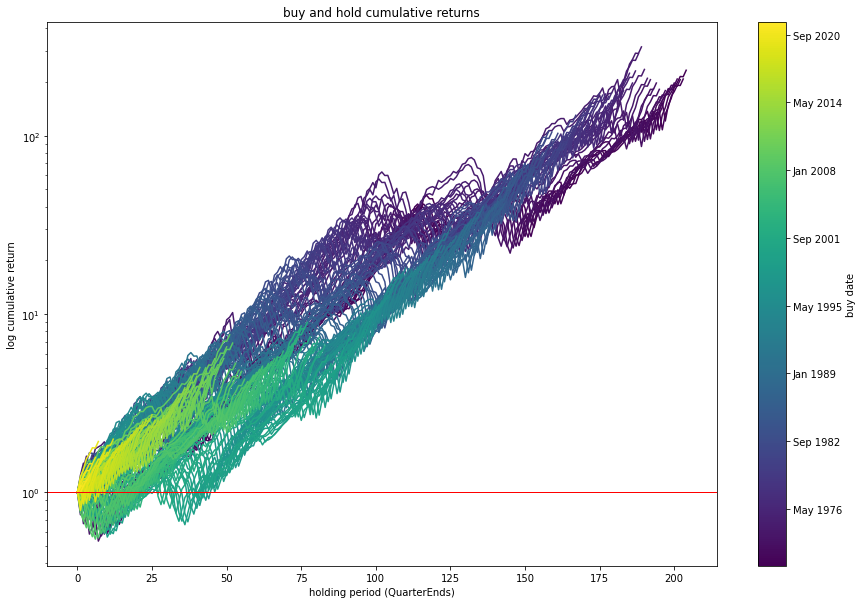

In [6]:
buy_freq = frequencies.to_offset(buy_freq)
ax, cbar = plot_tseries_with_colorbar_legend(
    rolling_buy_and_hold_returns(prices, buy_freq), 
    logy=True, 
    figsize=(15,10)
)
ax.set_title("buy and hold cumulative returns")
ax.set_ylabel("log cumulative return")
ax.set_xlabel(f"holding period ({buy_freq.__class__.__name__}s)")
ax.axhline(y=1, color="r", linewidth=1)
cbar.set_label("buy date")